In [1]:
!pip install tensorflow
!pip install transformers tensorboard --upgrade

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 9.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling tensorboard-2.12.0:
      Successfully uninstalled tensorboard-2.12.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 8.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 9.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.

### DigiFace-1M Dataset

https://github.com/microsoft/DigiFace1M

The DigiFace-1M dataset is a collection of over one million diverse synthetic face images for face recognition.

It was introduced in our paper DigiFace-1M: 1 Million Digital Face Images for Face Recognition and can be used to train deep learning models for facial recognition.

The dataset contains:

    720K images with 10K identities (72 images per identity). For each identity, 4 different sets of accessories are sampled and 18 images are rendered for each set.
    500K images with 100K identities (5 images per identity). For each identity, only one set of accessories is sampled.

The DigiFace-1M dataset can be used for non-commercial research, and is licensed under the license found in LICENSE.

In [2]:
import os

home=os.path.abspath(os.getcwd())
data_path=os.path.join(home, 'data')

#global data
pairs=[]
classes=[]
IMAGE_DIMS = 224 # was 224 pixels

for file in os.listdir(data_path):
    classes.append(file)
    

In [3]:
print(len(classes))

2000


In [4]:
import cv2

def preprocess(img, size=IMAGE_DIMS, interpolation =cv2.INTER_AREA):
    #extract image size
    h, w = img.shape[:2]
    #check color channels
    c = None if len(img.shape) < 3 else img.shape[2]
    #square images have an aspect ratio of 1:1
    if h == w: 
        return cv2.resize(img, (size, size), interpolation)
    elif h>w:#height is larger
        diff= h-w
        img=cv2.copyMakeBorder(img,0,0,int(diff/2.0),int(diff/2.0),cv2.BORDER_CONSTANT, value = 0)
        # img=cv2.copyMakeBorder(img,0,0,int(diff/2.0),int(diff/2.0),cv2.BORDER_REPLICATE)
    elif h<w:
        diff= w-h
        # img=cv2.copyMakeBorder(img,int(diff/2.0),int(diff/2.0),0,0,cv2.BORDER_REPLICATE)
        img=cv2.copyMakeBorder(img,int(diff/2.0),int(diff/2.0),0,0,cv2.BORDER_CONSTANT, value = 0)
    return cv2.resize(img, (size, size), interpolation)

In [5]:
import numpy as np

def scale_back(img, size=IMAGE_DIMS):
  h, w = img.shape[:2]
  c = None if len(img.shape) < 3 else img.shape[2]
  dif = size-h
  x_pos = int((dif)/2.0)
  y_pos = int((dif)/2.0)
  mask = np.zeros((size, size, c), dtype=img.dtype)
  mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
#   print(mask.shape)
  # cv2.imshow("test",mask)
  # cv2.waitKey(0)
  return mask

In [60]:
import numpy as np
import cv2
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(IMAGE_DIMS,IMAGE_DIMS), n_channels=1,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X = self.__data_generation(list_IDs_temp)
        return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        x1 = np.empty((self.batch_size, IMAGE_DIMS,IMAGE_DIMS,3))
        x2 = np.empty((self.batch_size, IMAGE_DIMS,IMAGE_DIMS,3))
        # x1 = np.empty((self.batch_size, 3, IMAGE_DIMS,IMAGE_DIMS))
        # x2 = np.empty((self.batch_size, 3, IMAGE_DIMS,IMAGE_DIMS))
        y = np.empty((self.batch_size, 1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # print(self.labels[int(ID)])
            path1, path2, label, s1, s2 = self.labels[int(ID)]

            _x1 = cv2.imread(path1)
            _x2 = cv2.imread(path2)
            _x1 = preprocess(_x1, s1)
            _x1 = scale_back(_x1) / 255.
            _x2 = preprocess(_x2, s2)
            _x2 = scale_back(_x2) / 255.

            x1[i,] = _x1
            x2[i,] = _x2
            y[i,] = label
        return [x1, x2], y



In [61]:
import random
import numpy as np

def make_pairs():#makes pairs of data
    global pairs, classes, labels
    # pairs = np.array(pairs).astype("float32")
    # labels = np.array(labels).astype("float32")
    # pairs = []
    for class_ in classes:
        class_path = os.path.join(data_path, class_)
        for img_path in os.listdir(class_path):
            if np.random.uniform()<=0.25:#rescale images
                image1 = os.path.join(class_path, img_path)
                image_select=random.choice(os.listdir(class_path))
                image2 = os.path.join(class_path, image_select)
                scale = np.random.uniform(0.3,0.6)#scaling factor
                select_index = random.choice([1,2])
                if select_index==1:
                    s1=int(scale*IMAGE_DIMS)#scale down
                    s2 = IMAGE_DIMS
                    scale_flag=1
                else:
                    s2=int(scale*IMAGE_DIMS)#scale down
                    s1 = IMAGE_DIMS
                    scale_flag=2
                pairs+=[[image1, image2, 1, s1, s2]]

                class_select = random.choice(classes)
                while class_select == class_:# keep trying if select the current class
                    class_select = random.choice(classes)
                class_path2 = os.path.join(data_path, class_select)
                image_select=random.choice(os.listdir(class_path2))
                image2 = os.path.join(class_path2, image_select)
                if scale_flag ==1:
                    s1 = IMAGE_DIMS
                    if np.random.uniform()<0.5:
                        s2=int(scale*IMAGE_DIMS)#scale down
                    else:
                        s2 = IMAGE_DIMS
                elif scale_flag ==2:
                    if np.random.uniform()<0.5:
                        select_index = random.choice([1,2])
                        if select_index==1:
                            s1=int(scale*IMAGE_DIMS)#scale down
                            s2 = IMAGE_DIMS
                        else:
                            s2=int(scale*IMAGE_DIMS)#scale down
                            s1 = IMAGE_DIMS
                scale_flag=0
                pairs+=[[image1, image2, 0, s1, s2]]

            image1 = os.path.join(class_path, img_path)
            image_select=random.choice(os.listdir(class_path))
            image2 = os.path.join(class_path, image_select)
            # image1=preprocess(image1)
            # image2=preprocess(image2)
            pairs+=[[image1, image2, 1, IMAGE_DIMS, IMAGE_DIMS]]


            class_select = random.choice(classes)
            while class_select == class_:# keep trying if select the current class
                class_select = random.choice(classes)
            class_path2 = os.path.join(data_path, class_select)
            image_select=random.choice(os.listdir(class_path2))
            image2 = os.path.join(class_path2, image_select)
            # image2=preprocess(image2)
            pairs+=[[image1, image2, 0, IMAGE_DIMS, IMAGE_DIMS]]




In [62]:
make_pairs()

In [66]:
pairs

[['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/68.png',
  '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/47.png',
  1,
  106,
  224],
 ['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/68.png',
  '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1313/34.png',
  0,
  224,
  106],
 ['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/68.png',
  '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/17.png',
  1,
  224,
  224],
 ['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/68.png',
  '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1597/39.png',
  0,
  224,
  224],
 ['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/13.png',
  '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/47.png',
  1,
  224,
  224],
 ['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/13.png',
  '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1409/22.png',
  0,
  224,
  224],
 ['/home/halim/Documents/ECE

In [67]:
pairs_len = len(pairs)
print(len(pairs))
print(pairs[0])

1080370
['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/68.png', '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/1634/47.png', 1, 106, 224]


In [68]:
print(pairs[pairs_len-1])

['/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/256/55.png', '/home/halim/Documents/ECE613/GitHub/Face_id_meta/data/447/60.png', 0, 224, 224]


In [69]:
#60/20/20
import math

# partition = {'train': np.arange(len(pairs)*.6),
#              'validation': np.arange(len(pairs)*.6,len(pairs)*.8),
#              'test': np.arange(len(pairs)*.8, len(pairs))}

partition = {'train': np.arange(math.floor(len(pairs)*.6)),
             'validation': np.arange(math.floor(len(pairs)*.6),math.floor(len(pairs)*.8)),
             'test': np.arange(math.floor(len(pairs)*.8), math.floor(len(pairs)))}

In [70]:
partition

{'train': array([     0,      1,      2, ..., 648219, 648220, 648221]),
 'validation': array([648222, 648223, 648224, ..., 864293, 864294, 864295]),
 'test': array([ 864296,  864297,  864298, ..., 1080367, 1080368, 1080369])}

In [71]:
# Generators
train_generator = DataGenerator(partition['train'], pairs, batch_size=16)
val_generator = DataGenerator(partition['validation'], pairs, batch_size=16)


In [203]:
print(len(train_generator)) 
print(len(train_generator[0])) # number of batches
print(len(train_generator[0][1])) # access images or label # return [x1, x2], y (0 to 1)
print(len(train_generator[0][0][0])) # choose image here x1 or x2 (0 to 1)
print(len(train_generator[0][0][0][15])) # which item in batch 0 to 15
print(len(train_generator[0][0][0][0][223])) # 0 to 224
print(len(train_generator[0][0][0][0][0][223])) # 0 to 224
# print(len(train_generator[0][0][0][0][0][0][0]))

40513
2
16
16
224
224
3


In [206]:
print(len(train_generator)) 
print(len(train_generator[0])) 
print(len(train_generator[0][1])) # access images or label # return [x1, x2], y (0 to 1)
print(len(train_generator[0][1][15])) # which item in batch 0 to 15

40513
2
16
1


In [161]:
# test_x1 = np.empty((10, 4,4,2))
# test_x2 = np.empty((10, 4,4,2))
# test_y = np.empty((10, 1))

In [160]:
# for i in range(0,10):
#     test_x1[i,] = 1

# test_x1

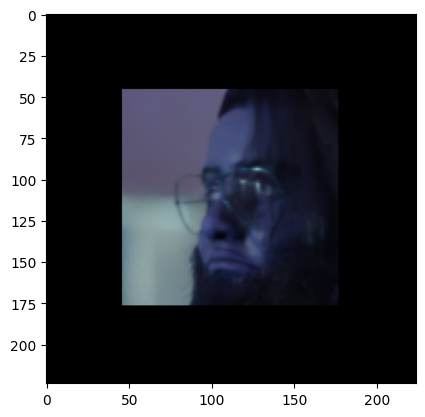

In [73]:
import matplotlib.pyplot as plt

#2*16*224*224*3
#first index: which batch
#2nd index: image or label
#3rd index: which image of the pair (x1 or x2)
#4th index: which element of the batch
img = train_generator[0][0][1][0]
label = train_generator[0][1]
plt.imshow(img)

In [75]:
type(img)

numpy.ndarray

In [76]:
img = train_generator[0][0][1][0]
img.shape

(224, 224, 3)

In [79]:
b_img = np.transpose(img, (2, 0, 1))
b_img.shape

(3, 224, 224)

In [47]:
train_generator[0][0][0]

array([[[[0.80392157, 0.79607843, 0.78823529],
         [0.80392157, 0.79607843, 0.78823529],
         [0.80392157, 0.79607843, 0.78823529],
         ...,
         [0.05098039, 0.04705882, 0.04313725],
         [0.05490196, 0.05098039, 0.04705882],
         [0.05490196, 0.05098039, 0.04705882]],

        [[0.80392157, 0.79607843, 0.78823529],
         [0.80392157, 0.79607843, 0.78823529],
         [0.80392157, 0.79607843, 0.78823529],
         ...,
         [0.05098039, 0.04705882, 0.04313725],
         [0.05098039, 0.04705882, 0.04313725],
         [0.05490196, 0.05098039, 0.04705882]],

        [[0.80392157, 0.79607843, 0.78431373],
         [0.80392157, 0.79607843, 0.78431373],
         [0.80392157, 0.79607843, 0.78823529],
         ...,
         [0.04705882, 0.04313725, 0.03921569],
         [0.05098039, 0.04705882, 0.04313725],
         [0.05098039, 0.04705882, 0.04313725]],

        ...,

        [[0.69411765, 0.72941176, 0.7254902 ],
         [0.69411765, 0.72941176, 0.7254902 ]

### Pre-trained Model

In this example are we going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

You can easily adjust the `model_id` to another Vision Transformer model, e.g. `google/vit-base-patch32-384`

In [16]:
model_id = "google/vit-base-patch16-224-in21k"

### Pre-processing

To train our model we need to convert our "Images" to `pixel_values`. This is done by a [🤗 Transformers Feature Extractor](https://huggingface.co/docs/transformers/master/en/main_classes/feature_extractor#feature-extractor) which allows us to `augment` and convert the images into a 3D Array to be fed into our model.

In [17]:
# from transformers import ViTFeatureExtractor
# from tensorflow import keras 
# from tensorflow.keras import layers


# feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# # learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
# data_augmentation = keras.Sequential(
#     [
#         layers.Resizing(feature_extractor.size, feature_extractor.size),
#         layers.Rescaling(1./255),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )
# # use keras image data augementation processing
# def augmentation(examples):
#     # print(examples["img"])
#     examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
#     return examples


# # basic processing (only resizing)
# def process(examples):
#     examples.update(feature_extractor(examples['img'], ))
#     return examples

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

class L1Dist(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, embedding1, embedding2):
        return tf.math.abs(embedding1-embedding2)


class L1Dist_mod(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, embedding1, embedding2):
        return tf.math.reduce_sum(tf.math.abs(embedding1-embedding2), axis=1, keepdims=True)

class L2Dist(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, embedding1, embedding2):
        sum_square = tf.math.reduce_sum(tf.math.square(embedding1 - embedding2), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

class cosine(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, embedding1, embedding2):
        return 1-tf.keras.losses.cosine_similarity(embedding1,embedding2)

class TF_L2Dist(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, embedding1, embedding2):
        return tf.math.reduce_euclidean_norm(embedding1,embedding2)

### Download the pretrained transformer model and fine-tune it. 

In [19]:
# from transformers import TFViTForImageClassification, create_optimizer
# import tensorflow as tf

# # create optimizer wight weigh decay
# num_train_steps = len(tf_train_dataset) * num_train_epochs
# optimizer, lr_schedule = create_optimizer(
#     init_lr=learning_rate,
#     num_train_steps=num_train_steps,
#     weight_decay_rate=weight_decay_rate,
#     num_warmup_steps=num_warmup_steps,
# )

# # load pre-trained ViT model
# model = TFViTForImageClassification.from_pretrained(
#     model_id,
#     num_labels=len(img_class_labels),
#     id2label=id2label,
#     label2id=label2id,
# )

# # define loss
# loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # define metrics 
# metrics=[
#     tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#     tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
# ]

# # compile model
# model.compile(optimizer=optimizer,
#               loss=loss,
#               metrics=metrics
#               )

If you want to create you own classification head or if you want to add the augmentation/processing layer to your model, you can directly use the [functional Keras API](https://keras.io/guides/functional_api/). Below you find an example on how you would create a classification head.

In [20]:
# import tensorflow as tf
# from transformers import TFViTModel

# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [21]:
# base_model.summary()

In [207]:
# alternatively create Image Classification model using Keras Layer and ViTModel 
# here you can also add the processing layers of keras

import tensorflow as tf
from transformers import TFViTModel
from tensorflow.keras import regularizers
from tensorflow.keras import layers

def make_siamese_net():
    base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    # base_model.summary()

    # inputs
    pixel_values1 = tf.keras.layers.Input(shape=(IMAGE_DIMS,IMAGE_DIMS, 3), name='pixel_values1', dtype='float32')
    pixel_values2 = tf.keras.layers.Input(shape=(IMAGE_DIMS,IMAGE_DIMS, 3), name='pixel_values2', dtype='float32')

    # b_img = np.transpose(img, (2, 0, 1))
    # b_img = np.transpose(img, (2, 0, 1))
    p1 = layers.Permute((3, 1, 2), input_shape=(IMAGE_DIMS,IMAGE_DIMS, 3))(pixel_values1)
    p2 = layers.Permute((3, 1, 2), input_shape=(IMAGE_DIMS,IMAGE_DIMS, 3))(pixel_values2)
  

    # model layer
    # vit = base_model.vit(pixel_values)[0]
    vit1 = base_model.vit(p1)[0]
    vit2 = base_model.vit(p2)[0]

    x1 = layers.Dense(1024, activation='sigmoid',kernel_regularizer=regularizers.l2(1e-3))(vit1)
    x2 = layers.Dense(1024, activation='sigmoid',kernel_regularizer=regularizers.l2(1e-3))(vit2)

    siamese_layer=L1Dist_mod()
    distances=siamese_layer(x1, x2)

    # classifier = tf.keras.layers.Dense(1, activation='softmax', name='outputs')(distances)
    classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(distances)

    # model
    keras_model = tf.keras.Model(inputs=[pixel_values1,pixel_values2] , outputs=classifier,name="siamese_network")

    return keras_model

In [208]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [209]:
siamese_net=make_siamese_net()
siamese_net.summary()


All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pixel_values1 (InputLayer)     [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 pixel_values2 (InputLayer)     [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 permute_6 (Permute)            (None, 3, 224, 224)  0           ['pixel_values1[0][0]']          
                                                                                    

In [210]:
# siamese_net.add_loss(loss(1))
siamese_net.compile(loss=loss(1), optimizer=tf.keras.optimizers.Adam(learning_rate=0.5e-6), 
                    metrics=["accuracy"])

In [211]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = os.path.join(home, 'checkpoints')
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
early_callback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=35, restore_best_weights=True)

In [212]:
from keras.callbacks import LearningRateScheduler

# callbacks_list = [early_callback,checkpoint]
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        lr = lr * tf.math.exp(-0.05)
        if lr >= 1e-8:
            return lr
        else:
            return 1e-8
# 0.5e-7

class print_lr(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(keras.backend.eval(self.model.optimizer.lr))

lr_sched = LearningRateScheduler(scheduler)

callbacks_list = [early_callback, lr_sched, checkpoint, print_lr()]

In [213]:
# Fit the model
# siamese_net = keras.models.load_model('checkpoints', custom_objects={ 'contrastive_loss': loss(1) })

batch_size=32
epochs=500
history = siamese_net.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=callbacks_list,
    epochs=epochs,
)
# history = siamese_net.fit(
#     [x_train_1, x_train_2],
#     y_train,
#     validation_data=([x_val_1, x_val_2], y_val),
#     batch_size=batch_size,
#     callbacks=callbacks_list,
#     epochs=epochs,
#     # sample_weight=sample_weight,
# )

print(max(history.history["val_accuracy"]))

Epoch 1/500
    2/40513 [..............................] - ETA: 224:10:55 - loss: 2.1930 - accuracy: 0.5625

: 

: 

In [ ]:
#https://github.com/huggingface/transformers/issues/2256